In [2]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix,parallel_coordinates
import seaborn as sns
import plotly.express as px
from folium.plugins import HeatMap
import folium
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.preprocessing import scale,LabelEncoder,StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report,silhouette_samples, silhouette_score
import xgboost
import tensorflow as tf
from tensorflow import keras
import shap

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from yellowbrick.cluster.elbow import kelbow_visualizer


from scipy import stats

from statsmodels.tsa.ar_model import AutoReg, ARResults
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from datetime import datetime
from meteostat import Point, Monthly

In [3]:
df_wout=pd.read_csv('df_wout.csv')

In [22]:
df_us=pd.read_csv('uscities.csv')

# Predict Weather Delay By Weather Data

In [4]:
df_weather_del=df_wout.loc[:,['weather_ct','weather_delay','year_month','city']]

In [5]:
df_weather_del['weather_del_dur']=df_weather_del['weather_delay']/df_weather_del['weather_ct']

df_weather_del['year_month_city']=df_weather_del['year_month']+'-'+df_weather_del['city']

In [6]:
np.sum(df_weather_del.isna())

weather_ct             0
weather_delay          0
year_month             0
city                   0
weather_del_dur    19916
year_month_city        0
dtype: int64

In [7]:
df_weather_del.fillna(0,inplace=True)

In [8]:
np.argmax(df_weather_del.weather_del_dur)

3204

In [9]:
df_weather_del.iloc[3204,:]

weather_ct                          0.0
weather_delay                       1.0
year_month                      2019-04
city                       Philadelphia
weather_del_dur                     inf
year_month_city    2019-04-Philadelphia
Name: 3204, dtype: object

In [10]:
df_weather_del[df_weather_del['weather_del_dur']==np.inf]

,weather_ct,weather_delay,year_month,city,weather_del_dur,year_month_city
3204,0.0,1.0,2019-04,Philadelphia,inf,2019-04-Philadelphia
7367,0.0,1.0,2012-11,Portland,inf,2012-11-Portland
7987,0.0,2.0,2019-10,Miami,inf,2019-10-Miami
8407,0.0,1.0,2009-03,Denver,inf,2009-03-Denver
27328,0.0,1.0,2005-03,Chicago,inf,2005-03-Chicago
52556,0.0,1.0,2007-09,Atlanta,inf,2007-09-Atlanta
66694,0.0,1.0,2015-12,Portland,inf,2015-12-Portland


In [11]:
df_weather_del=df_weather_del.drop(df_weather_del[df_weather_del['weather_del_dur']==np.inf].index,axis=0)

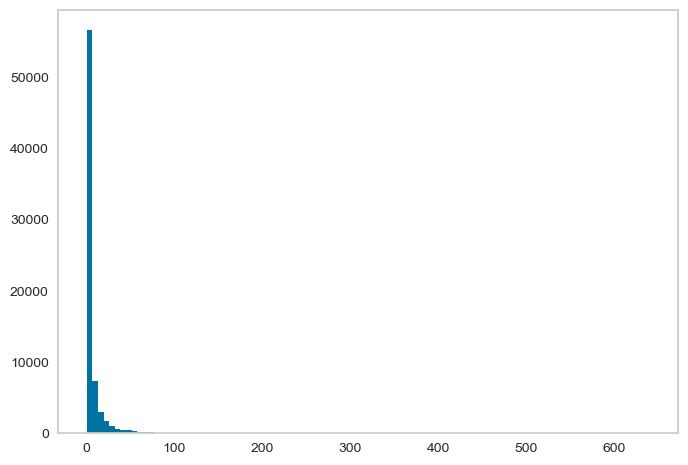

In [12]:
#plt.hist(df_weather_del.weather_del_dur,bins=100);
plt.hist(df_weather_del.weather_ct,bins=100)
plt.grid();

In [13]:
np.argmax(df_weather_del.weather_del_dur)

45624

In [14]:
df_weather_del.iloc[45624,:]

weather_ct                    0.99
weather_delay                815.0
year_month                 2017-11
city                       Chicago
weather_del_dur         823.232323
year_month_city    2017-11-Chicago
Name: 45629, dtype: object

In [15]:
#Dealing with outliers
#zscore method

out_low=df_weather_del[stats.zscore(df_weather_del['weather_del_dur'])<-3]
out_high=df_weather_del[stats.zscore(df_weather_del['weather_del_dur'])>3]

In [16]:
out_low.shape

(0, 6)

In [17]:
out_high.shape

(985, 6)

In [18]:
df_weather_del_wout=df_weather_del.drop(out_low.index,axis=0)
df_weather_del_wout=df_weather_del.drop(out_high.index,axis=0)

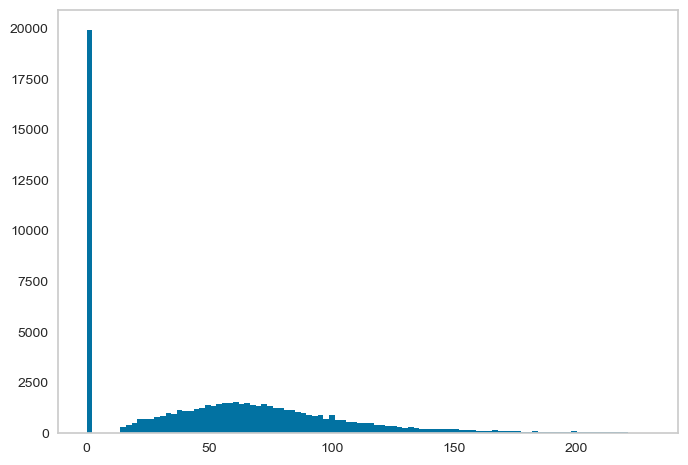

In [20]:
plt.hist(df_weather_del_wout.weather_del_dur,bins=100)
plt.grid();

<AxesSubplot:xlabel='weather_del_dur'>

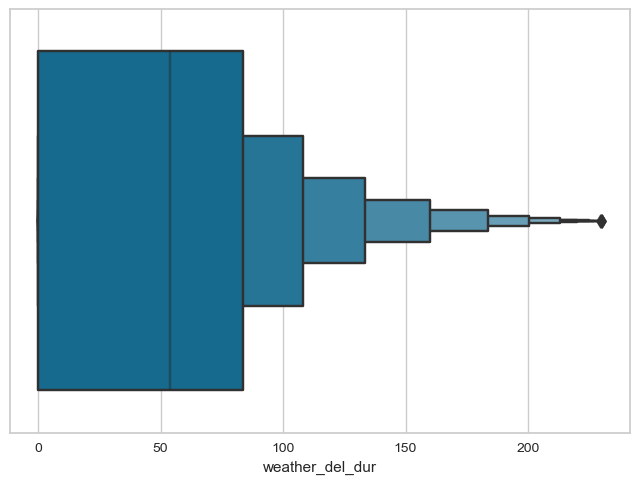

In [21]:
sns.boxenplot(df_weather_del_wout.weather_del_dur)

In [23]:
start = datetime(2003, 1, 1)
end = datetime(2020, 12, 31)
d = pd.DataFrame()
for i in range(df_us.shape[0]):
    point=Point(df_us.iloc[i,3],df_us.iloc[i,4])
    data = Monthly(point, start, end)
    temp=data.fetch()
    temp['city']=df_us.iloc[i,0]
    d = pd.concat([d, temp])

# Weather Data Description:

* tavg 	The average air temperature in °C 	Float64
* tmin 	The minimum air temperature in °C 	Float64
* tmax 	The maximum air temperature in °C 	Float64
* prcp 	The monthly precipitation total in mm 	Float64
* wspd 	The average wind speed in km/h 	Float64
* pres 	The average sea-level air pressure in hPa 	Float64
* tsun 	The monthly sunshine total in minutes (m) 	Float64

In [24]:
d.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun,city
time,,,,,,,,
2003-01-01,-2.2,-6.0,1.0,74.8,19.2,1015.3,NaN,New York
2003-02-01,-1.4,-4.9,2.0,99.1,17.7,NaN,NaN,New York
2003-03-01,6.3,0.8,11.5,101.1,15.3,1015.9,NaN,New York
2003-04-01,10.1,5.3,14.5,61.5,17.9,NaN,NaN,New York
2003-05-01,15.1,10.6,19.3,87.7,13.7,NaN,NaN,New York


In [25]:
d.shape

(5832, 8)

In [26]:
np.sum(d.isna())

tavg      31
tmin       0
tmax       0
prcp       1
wspd       6
pres    1218
tsun    5475
city       0
dtype: int64

In [27]:
d1=d.drop(['pres','tsun'],axis=1)

In [28]:
np.sum(d1.isna())

tavg    31
tmin     0
tmax     0
prcp     1
wspd     6
city     0
dtype: int64

In [29]:
df_weather=d1.dropna()

In [30]:
df_weather

,tavg,tmin,tmax,prcp,wspd,city
time,,,,,,
2003-01-01,-2.2,-6.0,1.0,74.8,19.2,New York
2003-02-01,-1.4,-4.9,2.0,99.1,17.7,New York
2003-03-01,6.3,0.8,11.5,101.1,15.3,New York
2003-04-01,10.1,5.3,14.5,61.5,17.9,New York
2003-05-01,15.1,10.6,19.3,87.7,13.7,New York
...,...,...,...,...,...,...
2020-08-01,29.4,26.4,33.0,203.0,12.4,Fort Lauderdale
2020-09-01,28.3,25.7,31.9,410.0,11.8,Fort Lauderdale
2020-10-01,27.4,24.9,30.3,362.0,14.4,Fort Lauderdale


In [31]:
df_weather['date']=df_weather.index

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
df_weather.reset_index(inplace=True)

In [33]:
df_weather['year_month']=pd.to_datetime(df_weather['date']).dt.strftime('%Y-%m')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
df_weather['year_month_city']=df_weather['year_month']+"-"+df_weather['city']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
df_weather_merge=df_weather.loc[:,['year_month_city','tavg', 'prcp', 'wspd']]

In [36]:
df_weather_del_wout=pd.merge(df_weather_del_wout,df_weather_merge,how='left')

In [37]:
df_weather_del_pred=df_weather_del_wout.loc[:,['weather_del_dur','tavg', 'prcp', 'wspd']]

In [38]:
df_weather_del_pred.weather_del_dur.describe()

count    71693.000000
mean        54.994128
std         47.593829
min          0.000000
25%          0.000000
50%         53.668379
75%         83.516484
max        230.136986
Name: weather_del_dur, dtype: float64

# Wether delay classes:
* less than or equal to 5 min = No Delay
* delay greater than 5 min = Delay

In [39]:
df_weather_del_pred['del_weather_class']=df_weather_del_pred['weather_del_dur'].agg(lambda x: 0 if x<=5 else 1 )

In [40]:
data_w_org=df_weather_del_pred.drop(['weather_del_dur'],axis=1)

In [41]:
data_w_org.del_weather_class.value_counts()

1    51777
0    19916
Name: del_weather_class, dtype: int64

In [42]:
#2 class
dsw = np.random.rand(len(data_w_org[data_w_org['del_weather_class']==1])) < 0.5
data_w_org_ds=pd.concat([data_w_org[data_w_org['del_weather_class']==1][dsw],
                                 data_w_org[data_w_org['del_weather_class']==0]])
data_w_org_ds=data_w_org_ds.sample(frac=1)

In [43]:
data_w_org_ds.del_weather_class.value_counts()

1    25802
0    19916
Name: del_weather_class, dtype: int64

In [44]:
X_w=data_w_org_ds.loc[:,['tavg', 'prcp', 'wspd']]
y_w=data_w_org_ds.loc[:,['del_weather_class']]

In [45]:
Xw_train,Xw_test,yw_train,yw_test=train_test_split(X_w,y_w,test_size=0.2)

In [46]:
xgbw=xgboost.XGBClassifier(eta= 0.6, max_depth= 15, n_estimators= 100)
xgbw.fit(Xw_train,yw_train)
cmdxgbw=confusion_matrix(yw_test,xgbw.predict(Xw_test))
print('XGBoost Classifier : \n' , cmdxgbw)
print('\n',classification_report(yw_test, xgbw.predict(Xw_test)))

XGBoost Classifier : 
 [[1559 2465]
 [1699 3421]]

               precision    recall  f1-score   support

           0       0.48      0.39      0.43      4024
           1       0.58      0.67      0.62      5120

    accuracy                           0.54      9144
   macro avg       0.53      0.53      0.52      9144
weighted avg       0.54      0.54      0.54      9144



In [47]:
#Evaluate Model by training whole dataset with cross validation algorithm to prevent overfitting
data_w_org=data_w_org.sample(frac=1)
X_w_org=data_w_org.loc[:,['tavg', 'prcp', 'wspd']]
y_w_org=data_w_org.loc[:,['del_weather_class']]


CVS_xgb_w=cross_val_score(xgbw,X_w_org,y_w_org,cv=10)

cmd_xgb_org=confusion_matrix(y_w_org,xgbw.predict(X_w_org))

print( 'Average of cross validation scores =' , np.mean(CVS_xgb_w) , '\n')
print( 'Standard deviation of cross validation scores =' , np.std(CVS_xgb_w) , '\n' )
print('XGBoost Classifier : \n' , cmd_xgb_org,'\n')
print('\n',classification_report(y_w_org, xgbw.predict(X_w_org)))

Average of cross validation scores = 0.7065543163625037 

Standard deviation of cross validation scores = 0.0035330308101642754 

XGBoost Classifier : 
 [[ 9811 10105]
 [14644 37133]] 


               precision    recall  f1-score   support

           0       0.40      0.49      0.44     19916
           1       0.79      0.72      0.75     51777

    accuracy                           0.65     71693
   macro avg       0.59      0.60      0.60     71693
weighted avg       0.68      0.65      0.66     71693



In [303]:
explainer=shap.Explainer(xgbw.predict,Xw_test)
shap_values=explainer(Xw_test)

Exact explainer: 9169it [01:47, 77.08it/s]                                                                             


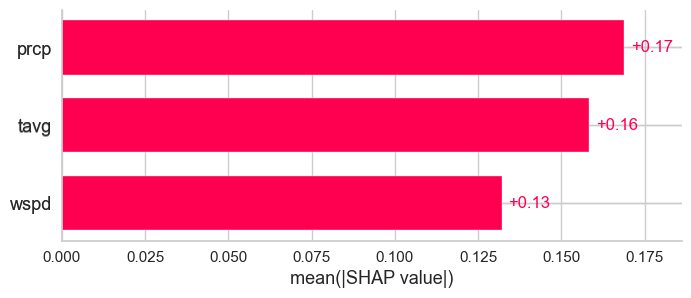

In [304]:
shap.plots.bar(shap_values)

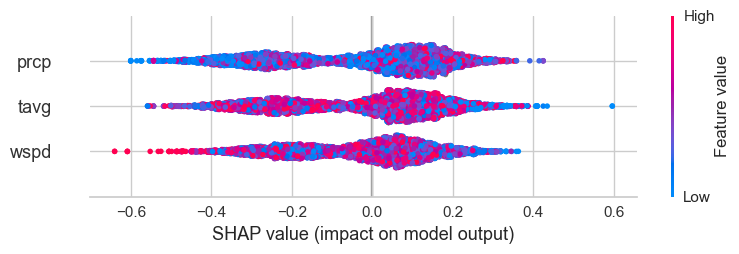

In [305]:
shap.summary_plot(shap_values)

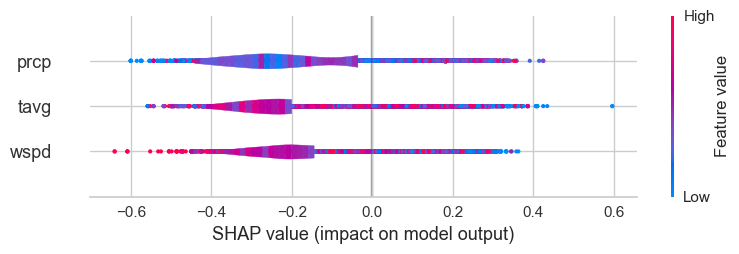

In [306]:
shap.summary_plot(shap_values, plot_type='violin')

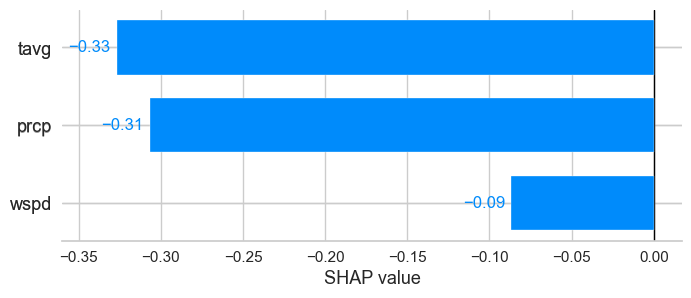

In [307]:
shap.plots.bar(shap_values[1])

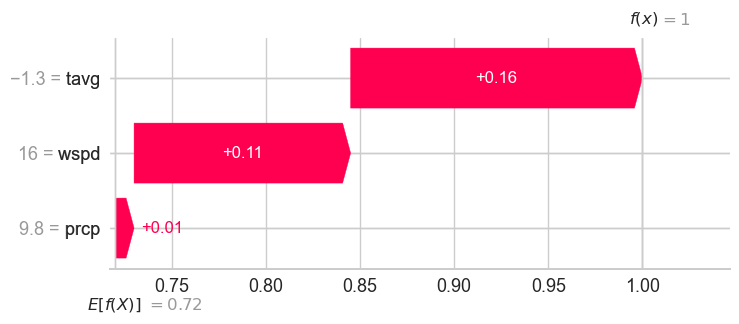

In [324]:
shap.plots.waterfall(shap_values[100])

In [48]:
#New Observation
tavg=20
prcp=0
wspd=16

In [49]:
predw=xgbw.predict(np.array([[tavg,prcp,wspd]]))[0]
if  predw==1:
    print("Delay !!!")
else:
    print( "No Delay due to weather","\U0001f600")

#Note: It's the predicted delay due to weather condition. If there is delay it's ok,
#but if model predict not, there might not be delay, There might be delay due to another reasons. 
#Actually, this model give the importance of weather features that is effective on weather delay.


No Delay due to weather 😀
